<a href="https://colab.research.google.com/github/GASKAP/SPARK/blob/master/SPARK_absorption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GASKAP absorption/emission regularized optimization

##Model

###Gaussian
\begin{equation}
  G(v_z, \theta_n) = a_n exp   \left( - \frac{\big(v_z - \mu_n\big)^2}{2 \sigma_n^2} \right)
\end{equation}

\begin{equation}
  \tilde \tau\big(v_z, \theta_{\tau}\big) = \sum_{n=1}^{N} G\big(v_z, \theta_{\tau,n}\big)
\end{equation}

###Cost function
\begin{equation}
  Q_{\tau}(\theta_{\tau}) = \frac{1}{2} ||L_{\tau}(v_z, \theta)||_{\Sigma_{\tau}}^2 
\end{equation}

###Spectral regularization
\begin{equation}
  R(\theta^{\rm Tb}, \theta^{\tau}) =  \frac{1}{2} \, \sum_{n=1}^N \lambda_{\mu} \|(\mu_n/\mu^{abs}_n) - 1\|_2^2 + \lambda_{\sigma} \|(\sigma_n/\sigma^{abs}_n) - 1\|_2^2
\end{equation}

###Full cost function
\begin{equation}
  J(\theta) = \lambda_{Tb} Q_{Tb}(\theta) + \lambda_{\tau} Q_{\tau}(\theta) + R(\theta^{\rm Tb}, \theta^{\tau})
\end{equation}

##Installation

In [1]:
import os
!rm -rf SPARK
!mkdir library
os.chdir('library')
!git clone https://github.com/GASKAP/SPARK
os.chdir('SPARK')
!pip install .
os.chdir('../../')

mkdir: cannot create directory ‘library’: File exists
fatal: destination path 'SPARK' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/library/SPARK
  Preparing metadata (setup.py) ... done
  Created wheel for SPARK: filename=SPARK-0.1.0-py3-none-any.whl size=22368 sha256=18154732c192914dcde8a543320dd504268d688f2e9dfe2d868faeec6afc2a68
  Stored in directory: /tmp/pip-ephem-wheel-cache-jowwurq8/wheels/57/a5/7a/549aec4072a7f4186ed3f4a13d7451bd685da3af4aea7337d6
Successfully built SPARK
  Attempting uninstall: SPARK
    Found existing installation: SPARK 0.1.0
    Uninstalling SPARK-0.1.0:
      Successfully uninstalled SPARK-0.1.0


##Getting started with the SPARK python package
###Import libraries

In [2]:
import numpy as np
from astropy.io import fits
import astropy.table as pytabs
import matplotlib.pyplot as plt

from SPARK.absorption import lbfgs_abs

###Run lbfgs_abs minimization

In [31]:
#Open 21-Sponge data
path = 'library/SPARK/data/'
name = '3C225A'

cat = fits.getdata(path+"sponge.fits")
data_s = pytabs.Table(cat)
idx_absline = np.where(data_s["NAMES"] == name)[0][0]
v = data_s[idx_absline]["VEL"]
Tb = data_s[idx_absline]["TB"]
tau = data_s[idx_absline]["TAU"]

#Channel spacing
dv = np.diff(v)[0]

#hdr
hdr=fits.Header()
hdr["CDELT3"] = dv
hdr["CRPIX3"] = 0
hdr["CRVAL3"] = v[0]*1.e3

#parameters                                                                                                                                                                                                                                                              
amp_fact_init = 2./3.
sig_init = 2.
iprint_init = -1
iprint = -1
maxiter_init = 15000
maxiter = 15000

n_gauss = 18            #@param {type:"slider", min:3, max:24, step:3} 
lambda_Tb = 1           #@param {type:"slider", min:1, max:100, step:10}
lambda_tau = 1          #@param {type:"slider", min:1, max:100, step:10}
lambda_mu = 1           #@param {type:"slider", min:0, max:100, step:10}
lambda_sig = 1          #@param {type:"slider", min:0, max:100, step:10}
lb_amp = 0.
ub_amp = np.max(Tb)
lb_mu = 1
ub_mu = len(tau)
lb_sig= 1
ub_sig = 30

core = lbfgs_abs(Tb=Tb, tau=tau, hdr=hdr)

result = core.run(n_gauss=n_gauss,
                  lb_amp=lb_amp,
                  ub_amp=ub_amp,
                  lb_mu=lb_mu,
                  ub_mu=ub_mu,
                  lb_sig=lb_sig,
                  ub_sig=ub_sig,
                  lambda_Tb=lambda_Tb,
                  lambda_tau=lambda_tau,
                  lambda_mu=lambda_mu,
                  lambda_sig=lambda_sig,
                  amp_fact_init=amp_fact_init,
                  sig_init=sig_init,
                  maxiter=maxiter,
                  maxiter_init=maxiter_init,
                  iprint=iprint,
                  iprint_init=iprint_init)


1.0 5.284370969047205
1.0 1.077349266459546
1.0 0.7384269684062295
1.0 0.11173716029325204
1.0 0.04863331348588345
1.0 0.01788888520725314
1.0 0.013483350665671932
1.0 0.008617642457795073
1.0 0.006249690037572707
1.0 0.005469271335048072
1.0 0.005336625015400811
1.0 0.005131452934629275
1.0 0.007520568645334015
1.0 0.004150924999087237
1.0 0.0041251205394514795
1.0 0.004100631151401354
1.0 0.004095180542654528
1.0 0.004091660945960826


In [24]:
result = result[0]

###Print Objective function

In [25]:
print("J =",result[1])

J = 0.06056316270424764


###Compute model

In [27]:
#Compute model                                                                                                                                                                                                                                                                
cube = np.moveaxis(np.array([Tb,tau]),0,1)
params = np.reshape(result[0], (3*n_gauss, cube.shape[1]))
vfield_Tb = core.mean2vel(hdr["CRVAL3"]*1.e-3, hdr["CDELT3"], hdr["CRPIX3"], 
                            params[1::3,0])
vfield_tau = core.mean2vel(hdr["CRVAL3"]*1.e-3, hdr["CDELT3"], hdr["CRPIX3"], 
                            params[1::3,1])

model_cube = core.model(params, cube, n_gauss)

###Plot figures

####Gaussian parameters

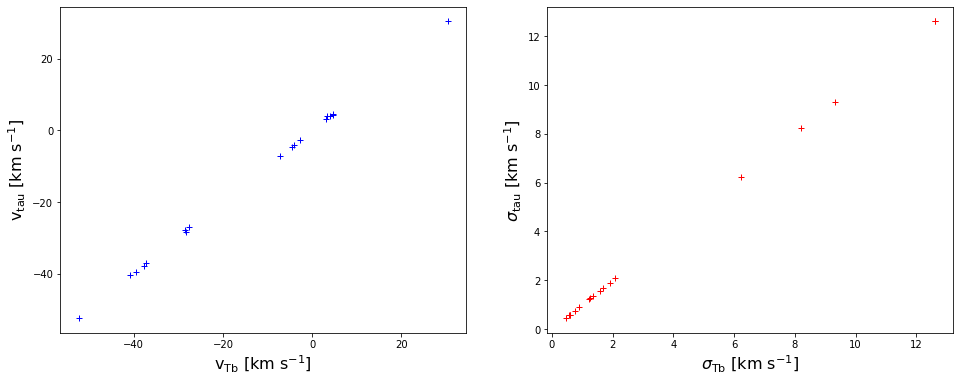

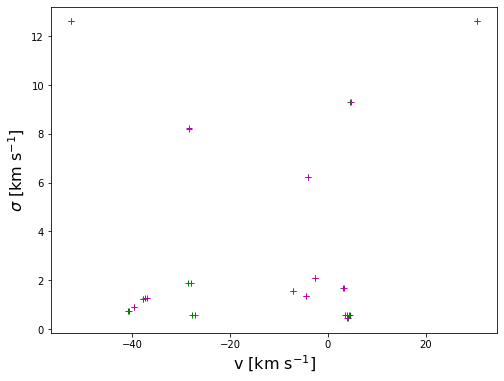

In [28]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(vfield_Tb, vfield_tau, "+b")
plt.xlabel(r"v$_{\rm Tb}$ [km s$^{-1}$]", fontsize=16)
plt.ylabel(r"v$_{\rm tau}$ [km s$^{-1}$]", fontsize=16)

plt.subplot(1,2,2)
plt.plot(params[:,0][2::3]*dv, params[:,1][2::3]*dv, "+r")
plt.xlabel(r"$\sigma_{\rm Tb}$ [km s$^{-1}$]", fontsize=16)
plt.ylabel(r"$\sigma_{\rm tau}$ [km s$^{-1}$]", fontsize=16)
plt.savefig("correlation.png", format='png', bbox_inches='tight', 
  pad_inches=0.02)

plt.figure(figsize=(8,6))
plt.subplot(1,1,1)
plt.plot(vfield_Tb, params[:,0][2::3]*dv, "+g")
plt.plot(vfield_tau, params[:,1][2::3]*dv, "+m")
plt.xlabel(r"v [km s$^{-1}$]", fontsize=16)
plt.ylabel(r"$\sigma$ [km s$^{-1}$]", fontsize=16)
plt.savefig("sigma_v.png", format='png', bbox_inches='tight', 
  pad_inches=0.02)



####Plot emission vs absorption spectrum

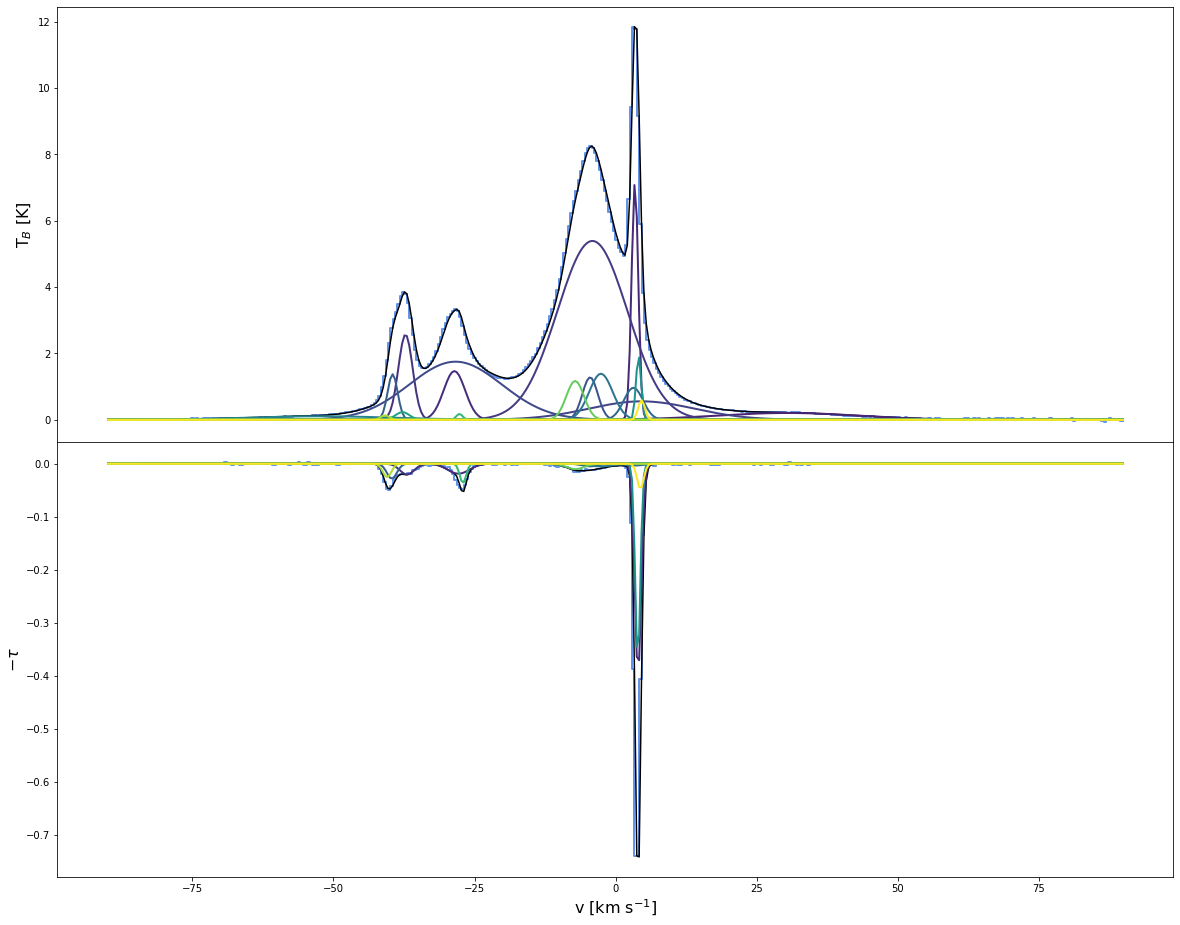

In [29]:
#Compute model                                                                                                                                                                                                                                                                
cube = np.moveaxis(np.array([Tb,tau]),0,1)
params = np.reshape(result[0], (3*n_gauss, cube.shape[1]))
model_cube = core.model(params, cube, n_gauss)

#Plot                                                                                                                                                                                                                                                                         
pvalues = np.logspace(-1, 0, n_gauss)
pmin = pvalues[0]
pmax = pvalues[-1]

def norm(pval):
    return (pval - pmin) / float(pmax - pmin)

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(20,16))
fig.subplots_adjust(hspace=0.)
x = np.arange(cube.shape[0])
ax1.step(v, cube[:,0], color='cornflowerblue', linewidth=2.)
ax1.plot(v, model_cube[:,0], color='k')
ax2.step(v, -cube[:,1], color='cornflowerblue', linewidth=2.)
ax2.plot(v, -model_cube[:,1], color='k')
for i in np.arange(cube.shape[1]):
    for k in np.arange(n_gauss):
        line = core.gaussian(x, params[0+(k*3),i], params[1+(k*3),i], 
                              params[2+(k*3),i])
        if i == 1:
            ax2.plot(v, -line, color=plt.cm.viridis(pvalues[k]), linewidth=2.)
        else:
            ax1.plot(v, line, color=plt.cm.viridis(pvalues[k]), linewidth=2.)

ax1.set_ylabel(r'T$_{B}$ [K]', fontsize=16)
ax2.set_ylabel(r'$- \tau$', fontsize=16)
ax2.set_xlabel(r'v [km s$^{-1}$]', fontsize=16)
plt.savefig("result_spectra.png", format='png', bbox_inches='tight', 
  pad_inches=0.02)


####Plot residuals

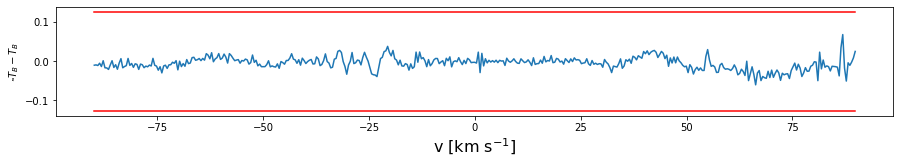

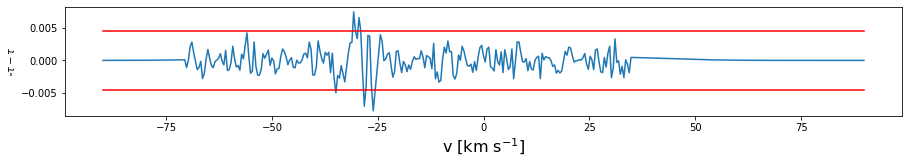

In [30]:
vmin=np.min(v); vmax=np.max(v)
rms_Tb = np.std(Tb[50:100]); rms_tau=np.std(tau[50:100])

plt.figure(figsize=(15,2))
plt.subplot(1,1,1)
plt.plot(v, model_cube[:,0] - Tb)
plt.plot([vmin,vmax], [-3.*rms_Tb,-3.*rms_Tb], color="r")
plt.plot([vmin,vmax], [3.*rms_Tb,3.*rms_Tb], color="r")
plt.xlabel(r'v [km s$^{-1}$]', fontsize=16)
plt.ylabel(r"$\tilde T_B - T_B$")
plt.savefig("residual_Tb.png", format='png', bbox_inches='tight', 
  pad_inches=0.02)

plt.figure(figsize=(15,2))
plt.subplot(1,1,1)
plt.plot(v, model_cube[:,1] - tau)
plt.plot([vmin,vmax], [-3.*rms_tau,-3.*rms_tau], color="r")
plt.plot([vmin,vmax], [3.*rms_tau,3.*rms_tau], color="r")
plt.xlabel(r'v [km s$^{-1}$]', fontsize=16)
plt.ylabel(r"$\tilde \tau - \tau$")
plt.savefig("residual_tau.png", format='png', bbox_inches='tight', 
  pad_inches=0.02)


Text(0, 0.5, 'a$_{\\rm tau}$')

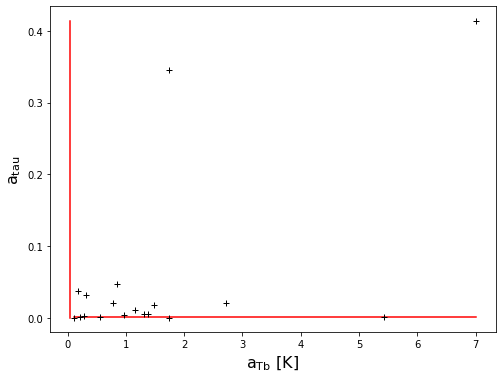

In [ ]:
plt.figure(figsize=(8,6))
plt.subplot(1,1,1)
plt.plot([np.min(params[:,0][0::3]), np.max(params[:,0][0::3])], 
          [rms_tau, rms_tau], "-r")
plt.plot([rms_Tb, rms_Tb], [np.min(params[:,1][0::3]), np.max(params[:,1][0::3])], "-r")
plt.plot(params[:,0][0::3], params[:,1][0::3], "+k")
plt.xlabel(r"a$_{\rm Tb}$ [K]", fontsize=16)
plt.ylabel(r"a$_{\rm tau}$", fontsize=16)

###Radiative transfer modeling

\begin{equation}
  T_{B, \rm abs}(v)=\sum_{n=0}^{N-1} T_{s, n}\left(1-e^{-\tau_{n}(v)}\right) e^{-\sum_{m=0}^{M} \tau_{m}(v)}
\end{equation}

\begin{equation}
  T_{B, \rm em}(v) = \sum_{k=0}^{K-1}\left[\mathcal{F}_{k}+\left(1-\mathcal{F}_{k}\right) e^{-\tau(v)}\right] \cdot T_{0, k} e^{\frac{-4 \ln 2\left(v-v_{0,k}, \right)^{2}}{\Delta_{v_k}^{2}}}
\end{equation}

In [ ]:
tau_lim = rms_tau

idx_em = np.where(params[0::3,1] < tau_lim)[0]
idx_abs = np.where(params[0::3,1] > tau_lim)[0]

model_Tb_em = np.zeros(len(core.tau))
for i in np.arange(len(idx_em)):
  model_Tb_em += core.gaussian(np.arange(len(core.tau)), 
                                  params[0::3,0][idx_em[i]], 
                                  params[1::3,0][idx_em[i]], 
                                  params[2::3,0][idx_em[i]]) 

model_Tb_abs = np.zeros(len(core.tau))
for i in np.arange(len(idx_abs)):
  model_Tb_abs += core.gaussian(np.arange(len(core.tau)), 
                                  params[0::3,0][idx_abs[i]], 
                                  params[1::3,0][idx_abs[i]], 
                                  params[2::3,0][idx_abs[i]])
  

print(len(idx_abs))
print(idx_abs)


13
[ 1  2  3  7  8  9 10 12 13 14 15 16 17]


97.14654670019038
260.73268825888664


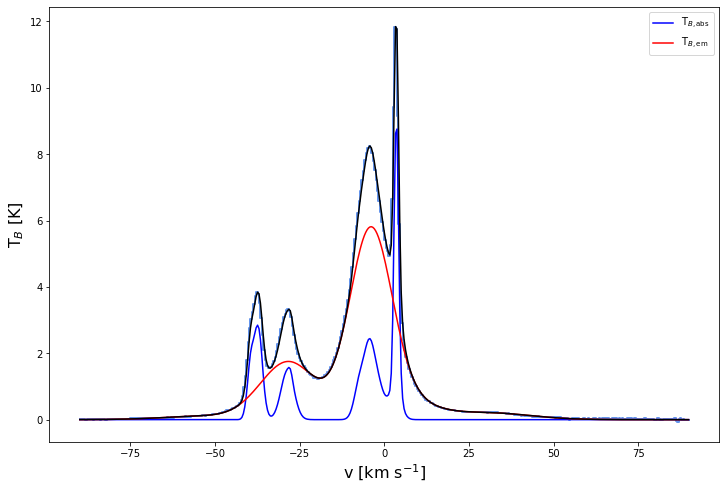

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(1,1,1)
plt.step(v, cube[:,0], color='cornflowerblue', linewidth=2.)
plt.plot(v, model_Tb_abs, "-b", label=r"T$_{B,\rm abs}$")
plt.plot(v, model_Tb_em, "-r", label=r"T$_{B,\rm em}$")
plt.plot(v, model_cube[:,0], "-k")
plt.xlabel(r'v [km s$^{-1}$]', fontsize=16)
plt.ylabel(r'T$_{B}$ [K]', fontsize=16)
plt.legend()
plt.savefig("model_TB_abs_em.png", format='png', bbox_inches='tight', 
  pad_inches=0.02)

print(np.sum(model_Tb_abs) * dv * 1.82243)
print(np.sum(model_Tb_em) * dv * 1.82243)

####Test modeling / in progress


In [ ]:
import random
Ts = 50. 
Tb_abs_model = np.zeros(len(v))
tau_in_front = np.zeros(len(v))
for i in np.arange(len(idx_abs)):
    tau_z = core.gaussian(np.arange(len(core.tau)), 
                                  params[0::3,1][idx_abs[i]], 
                                  params[1::3,1][idx_abs[i]], 
                                  params[2::3,1][idx_abs[i]])
    Tb_z = Ts * (1. - np.exp(-tau_z)) * np.exp(-tau_in_front)
    Tb_abs_model += Ts * Tb_z
    tau_in_front += tau_z

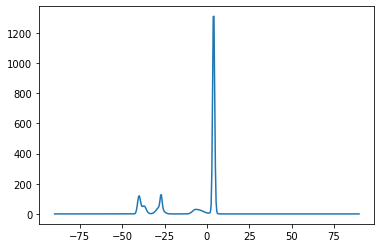

In [ ]:
plt.plot(v, Tb_abs_model)

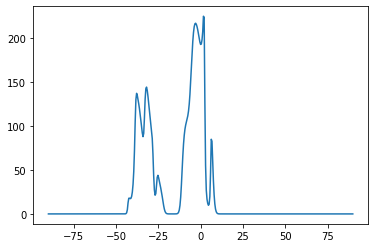

In [ ]:
plt.plot(v, model_Tb_abs / (1. - np.exp(-model_cube[:,1])))

In [ ]:
from astropy import constants as const
m_h = 1.6737236e-27 #kg 

Ts_naive = params[0::3,0][idx_abs] / (1. - np.exp(-params[0::3,1][idx_abs]))
Ts_naive_full = params[0::3,0] / (1. - np.exp(-params[0::3,1]))
TD = (params[2::3,0][idx_abs]*dv*1.e3)**2. * m_h / const.k_B.value


[  3.97026201 -27.8832962  -36.56079358  -4.53128013 -39.67846257
   3.36189529  -2.53325984   3.91928063 -37.35443036 -27.05749883
  -7.15139442 -40.42162499   4.27455562]


Text(0, 0.5, 'T$_{S,naive}$ [K]')

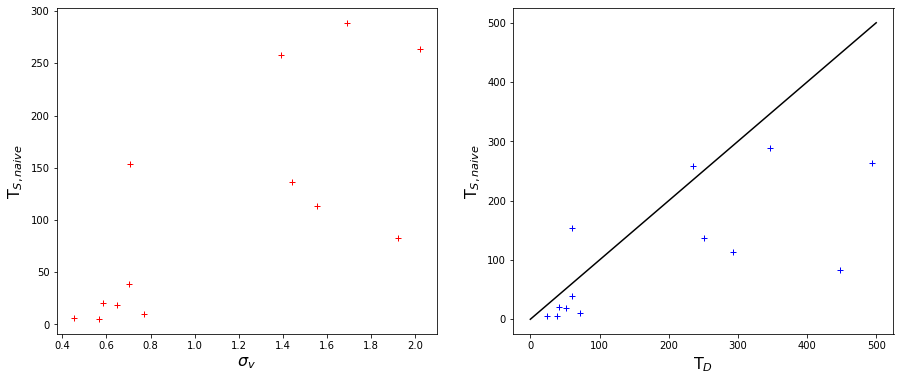

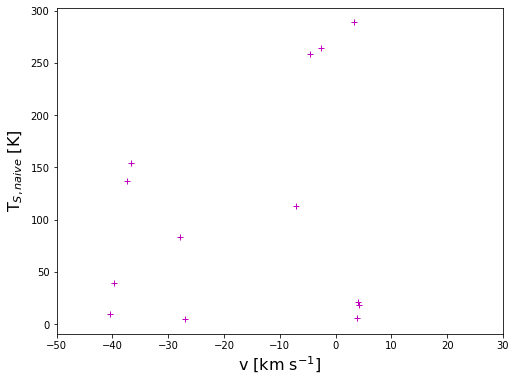

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
#plt.plot(params[2::3,0]*dv, Ts_naive_full, "+b")
plt.plot(params[2::3,0][idx_abs]*dv, Ts_naive, "+r")
plt.xlabel(r"$\sigma_v$", fontsize=16)
plt.ylabel(r"T$_{S,naive}$", fontsize=16)

plt.subplot(1,2,2)
#plt.plot(params[2::3,0]*dv, Ts_naive_full, "+b")
plt.plot(TD, Ts_naive, "+b")
plt.plot([0,500], [0,500], "-k")
plt.xlabel(r"T$_D$", fontsize=16)
plt.ylabel(r"T$_{S,naive}$", fontsize=16)
plt.savefig("TS_naive.png", format='png', bbox_inches='tight', 
  pad_inches=0.02)

plt.figure(figsize=(8,6))
plt.subplot(1,1,1)
print(np.array(vfield_tau)[idx_abs])
plt.plot(np.array(vfield_tau)[idx_abs], Ts_naive, "+m")
plt.xlim([-50,30])
plt.xlabel(r"v [km s$^{-1}$]", fontsize=16)
plt.ylabel(r"T$_{S,naive}$ [K]", fontsize=16)



In [ ]:
print(Ts_naive)

[ 20.68171746  83.00996029 154.03440128 258.37465079  39.07436853
 288.77841107 263.87644662   5.93819221 136.54066454   4.92199321
 113.30634325  10.00108549  18.57354911]


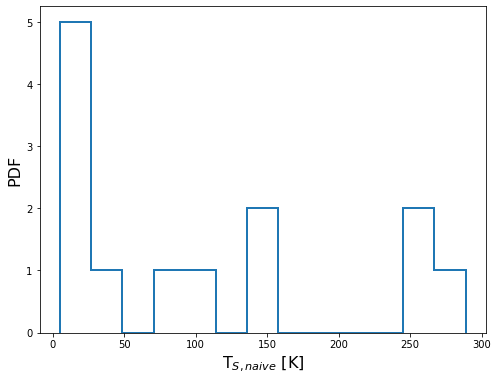

In [ ]:
plt.figure(figsize=(8,6))
plt.subplot(1,1,1)
plt.hist(Ts_naive, bins=len(Ts_naive), histtype="step", linewidth=2)
plt.xlabel(r"T$_{S,naive}$ [K]", fontsize=16)
plt.ylabel(r"PDF", fontsize=16)
plt.savefig("PDF_TS_naive.png", format='png', bbox_inches='tight', 
  pad_inches=0.02)